In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_augmentation import random_transform


from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras import applications
from keras.layers import Dense, Conv2D, MaxPooling2D, Reshape, Flatten, Input, merge, subtract, Lambda, Dropout
from keras import backend as K

Using TensorFlow backend.


In [2]:
resize_shape = (128, 128, 3)

In [3]:
data = pd.read_csv("data/train.csv")

# Take this out later
# data = data.head(500)

# Shuffle data

In [4]:
from sklearn.utils import shuffle
data = shuffle(data)

In [5]:
#For now, we remove new_whale
# data = data[data['Id'] != 'new_whale'].reset_index(drop=True)

In [6]:
len(data)

9850

# Look at example 

In [7]:
# data.head(10)

In [8]:
from PIL import Image
image = Image.open('data/train/00022e1a.jpg')

In [9]:
np.array(image).shape

(500, 699)

In [10]:
# plt.imshow(image)
# plt.show()

In [11]:
np.array(image).shape

(500, 699)

In [12]:
new_image = np.stack([image]*3,axis=2)

In [13]:
np.array(new_image).shape

(500, 699, 3)

In [14]:
# gray = np.mean(image, -1)

In [15]:
# gray.shape

In [16]:
# plt.imshow(random_transform(gray),cmap='gray')
# plt.show()

# All images (if small) can be held in memory.

In [17]:
file_list = data['Image']
id_list = data['Id']

In [18]:
def get_image(file, shape=(resize_shape[0],resize_shape[1])):
    image = Image.open('data/train/' + file)
    image = image.resize(shape)
    image = np.array(image)
    if len(image.shape) == 2:
        image = np.stack([image]*3,axis=2) 
    return image

In [19]:
image_list = [get_image(f) for f in file_list]

In [20]:
length_list = [len(image.shape) for image in image_list]

In [21]:
file_list[0]

'00022e1a.jpg'

In [22]:
data['image_array'] = image_list

In [23]:
data.head(4)

,Image,Id,image_array
276,069e0d01.jpg,w_6398e9d,"[[[226, 226, 226], [233, 233, 233], [228, 228,..."
447,0b02fbcd.jpg,w_0e96943,"[[[140, 140, 140], [140, 140, 140], [144, 144,..."
1667,2c367983.jpg,w_b7d5069,"[[[154, 165, 195], [133, 144, 174], [118, 121,..."
9297,f255197f.jpg,w_d37b55b,"[[[252, 252, 252], [252, 252, 252], [252, 252,..."


# Create Test and Train

In [24]:


test_proportion = 0.8
cutoff_index = int(len(data) * test_proportion)

training_data = data.iloc[:cutoff_index].reset_index(drop=True)
test_data = data.iloc[cutoff_index:].reset_index(drop=True)

In [25]:
from collections import Counter

training_counts = Counter(training_data['Id'])
training_data['Id_count'] = training_data.apply(lambda x: training_counts.get(x["Id"]), axis=1)

test_counts = Counter(test_data['Id'])
test_data['Id_count'] = test_data.apply(lambda x: test_counts.get(x["Id"]), axis=1)

[('new_whale', 652), ('w_1287fbc', 27), ('w_98baff9', 22), ('w_1eafe46', 22)]

In [26]:
from random import randint

# Create generator

In [27]:
def get_triple(len_data, data_images, data_ids, anchor_condition, augment=True):
    
    anchor_index = np.random.choice(anchor_condition.index[anchor_condition])    
    anchor_image = data_images[anchor_index]
    anchor_id = data_ids[anchor_index]   

    same_id = anchor_id    
    same_id_indices = (data_ids == anchor_id)
    same_id_index = np.random.choice(same_id_indices.index[same_id_indices])
    same_image = data_images[same_id_index]
    
    different_id = anchor_id
    
    while (anchor_id == different_id):
        different_index = randint(0,len_data-1)
        different_id = data_ids[different_index]
    
    different_image = data_images[different_index]
    
    if augment:
        anchor_image = random_transform(anchor_image)
        same_image = random_transform(same_image)
        different_image = random_transform(different_image)
    return anchor_image, same_image, different_image

In [28]:
def triple_generator(batch_size, data, resize_shape, augment=True):
    
    len_data = len(data)
    data_images = np.stack(data['image_array'])
    data_ids = data['Id']
    
    anchor_condition = (data['Id_count'] > 1) & (data_ids != 'new_whale')
        
    
    while True:
        anchor_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        same_image_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        different_image_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        for i in range(batch_size):
#             print("assigning next images...")
            anchor_batch[i,:,:,:], same_image_batch[i,:,:,:], different_image_batch[i,:,:,:] = get_triple(
                    len_data, data_images, data_ids, anchor_condition, augment)

        batches = [anchor_batch, same_image_batch, different_image_batch]
        yield batches, np.ones(batch_size)

In [29]:
# training_data_generator = triple_generator(16, training_data, resize_shape)

In [30]:
# len_data = len(training_data)
# data_images = np.stack(training_data['image_array'])
# data_ids = training_data['Id']
# anchor_condition = (training_data['Id_count'] > 1) & (data_ids != 'new_whale')

In [31]:
# get_triple(len_data, data_images, data_ids, anchor_condition)

In [32]:
# next(training_data_generator)

# Create the network

In [33]:
input_shape = resize_shape

anchor_input = Input(input_shape)
same_category_input = Input(input_shape)
different_category_input = Input(input_shape)

In [41]:
def bpr_triplet_loss(X):    
    margin = 3
    
    anchor_embedding, same_embedding, different_embedding = X
    
    positive_distance = K.square(anchor_embedding - same_embedding)
    negative_distance = K.square(anchor_embedding - different_embedding)
    
    positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
    negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
    
    loss = K.maximum(0.0, margin + positive_distance - negative_distance)
   
    return K.mean(loss)

def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus', alpha=0.1):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, alpha + loss)
    elif margin == 'softplus':
        loss = K.log(alpha + K.exp(loss))
    return K.mean(loss)    
    
convnet = Sequential()
convnet.add(Conv2D(filters=8, input_shape=(
    resize_shape[0],resize_shape[1],resize_shape[2],), kernel_size=5, activation='relu',name='conv_1'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_1'))
convnet.add(Conv2D(filters=12, kernel_size=3, activation='relu',name='conv_2'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_2'))
convnet.add(Conv2D(filters=16, kernel_size=3, activation='relu',name='conv_3'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_3'))
convnet.add(Conv2D(filters=20, kernel_size=3, activation='relu',name='conv_4'))
convnet.add(Conv2D(filters=32, kernel_size=3, activation='relu',name='conv_5'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_4'))
convnet.add(Flatten())
convnet.add(Dense(units=128, activation='relu',name='dense_1'))
convnet.add(Dense(units=128, activation='relu',name='dense_2'))
convnet.add(Dense(units=64, activation='relu',name='dense_3'))



anchor = convnet(anchor_input)
same = convnet(same_category_input)
different = convnet(different_category_input)

loss = merge(
        [anchor, same, different],
        mode=bpr_triplet_loss,
        name='loss',
        output_shape=(1, ))
    
siamese_net = Model(input=[anchor_input,same_category_input, different_category_input],output=loss)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("lo...)`


In [42]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

In [43]:
# LEARNING_RATE = 0.1
# siamese_net.compile(loss=identity_loss,optimizer=SGD(LEARNING_RATE))
siamese_net.compile(loss=identity_loss,optimizer=Adam())

# Model summary

In [293]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 124, 124, 8)       608       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 62, 62, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 60, 60, 12)        876       
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 30, 30, 12)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 16)        1744      
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 12, 12, 20)        2900      
__________

# Run the network

In [44]:
from keras.optimizers import Adam, SGD

In [45]:
BATCH_SIZE = 16
training_data_generator = triple_generator(BATCH_SIZE, training_data, resize_shape, augment=True)

In [46]:
# history = siamese_net.fit_generator(training_data_generator,
#                                     verbose=1, 
#                                     epochs=100, 
#                                     steps_per_epoch=100,
#                                     workers=8,
#                                     use_multiprocessing=True)

# Loss function 

In [47]:
plt.plot(history.history['loss'])
plt.title("Loss function")
plt.xlabel("epochs")
plt.show()

NameError: name 'history' is not defined

In [60]:
dates = ['2018.02.22 11:15:34',
'2018.02.22 11:56:28',
'2018.02.22 15:12:55',
'2018.02.22 16:03:18',
'2018.02.22 16:24:02',
'2018.02.22 17:23:20',
'2018.02.22 17:24:56',
'2018.02.22 17:50:34',
'2018.02.22 17:57:54',
'2018.02.22 19:17:11']


# Load weights

In [108]:
weights_folder = 'weights/' + dates[9] + '/'

convnet.load_weights(weights_folder + 'convnet_weights')
siamese_net.load_weights(weights_folder + 'siamese_weights')

# Evaluation 

In [113]:
evaluation_data_generator = triple_generator(BATCH_SIZE, test_data, resize_shape, augment=False)
evaluation_steps = 10
metric_names = siamese_net.metrics_names
metric_values = siamese_net.evaluate_generator(evaluation_data_generator, steps=evaluation_steps)
print("Metric names", metric_names)
print("Metric values", metric_values)

Metric names ['loss']
Metric values 0.3667676538228989


# Save weights

In [129]:
import time
import os

now = time.strftime('%Y.%m.%d %H:%M:%S')
weights_directory = "weights/" + now + "/"
if not os.path.exists(weights_directory):
    os.makedirs(weights_directory)


# siamese_net.save_weights(weights_directory + "siamese_weights")
# convnet.save_weights(weights_directory + "convnet_weights")

# Sub

In [114]:
# data = pd.read_csv("data/train.csv")
# file_list = data['Image']
# image_list = [get_image(f) for f in file_list]

In [115]:
# id_list = data['Id']

In [116]:
# Will want to change this to say trained embedding list. Or trained embeddings.

embedding_list = convnet.predict(np.stack(image_list))

In [131]:
def get_sub_image(file, shape=(resize_shape[0],resize_shape[1])):
    image = Image.open('data/test/' + file)
    image = image.resize(shape)
    image = np.array(image)
    if len(image.shape) == 2:
        image = np.stack([image]*3,axis=2) 
    return image


sample_sub = pd.read_csv("data/sample_submission.csv")


#Comment out:
# sample_sub = sample_sub.head(200)





submission_file_list = sample_sub['Image']
submission_image_list = [get_sub_image(f) for f in submission_file_list]

In [132]:
submission_embedding_list = convnet.predict(np.stack(submission_image_list))

In [133]:
def remove_duplicates(li):
    my_set = set()
    filtered = []
    for e in li:
        if e not in my_set:
            filtered.append(e)
            my_set.add(e)
    return filtered


def classify(image_embedding, embedding_list, id_list, num_categories=5):
    image_embedding = np.expand_dims(image_embedding, axis=0)
    stacked_image = np.repeat(image_embedding,len(embedding_list),axis=0)
    square_differences = (stacked_image - embedding_list)**2
    scores = np.sum(square_differences, axis=1)
    
    #Take out magic 3. Put in margin.
    
    scores = np.append(scores, [3], axis=0)
    id_list = np.append(id_list, ['new_whale'], axis=0)
    
    sorted_ids = [x for (y,x) in sorted(
        zip(scores,id_list), key=lambda pair: pair[0])]
    
    return ' '.join(remove_duplicates(sorted_ids)[0:num_categories])
    

In [134]:
classify(submission_embedding_list[7], embedding_list, id_list)

'new_whale w_eea20c4 w_9e7021b w_026fdf8 w_3d66298'

In [135]:
data.head(10)

,Image,Id,image_array
276,069e0d01.jpg,w_6398e9d,"[[[226, 226, 226], [233, 233, 233], [228, 228,..."
447,0b02fbcd.jpg,w_0e96943,"[[[140, 140, 140], [140, 140, 140], [144, 144,..."
1667,2c367983.jpg,w_b7d5069,"[[[154, 165, 195], [133, 144, 174], [118, 121,..."
9297,f255197f.jpg,w_d37b55b,"[[[252, 252, 252], [252, 252, 252], [252, 252,..."
6990,b591eaec.jpg,w_04c841c,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4540,762354c7.jpg,w_7285eb3,"[[[75, 116, 170], [86, 127, 181], [106, 149, 1..."
1316,22316c00.jpg,w_21e178f,"[[[43, 98, 128], [65, 120, 150], [85, 137, 187..."
4949,80666e5c.jpg,w_19f0b15,"[[[244, 244, 244], [244, 244, 244], [244, 244,..."
3144,51b599b6.jpg,w_dac2f44,"[[[232, 232, 232], [234, 234, 234], [230, 230,..."
9020,eafadfb3.jpg,w_6f31916,"[[[195, 195, 195], [209, 209, 209], [214, 214,..."


In [136]:
# submission_embedding_list

In [137]:
# submission_embedding_list[4]

In [138]:
submission_prediction_list = [classify(image_embedding, embedding_list, id_list) for image_embedding in submission_embedding_list]

In [139]:
submission = pd.DataFrame({'Image': submission_file_list, 'Id': submission_prediction_list}, columns=['Image','Id'])

# Save Results

In [141]:
results_directory = "results/" + now + "/"
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
    
submission.to_csv(results_directory + "submission.csv",index=False)

# Visualization

In [144]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [145]:
pca = PCA(n_components=2)

In [276]:
def color_from_string(s):
    if s == 'w_1287fbc':
        return 'red'
    if s == 'w_98baff9':
        return 'blue'
    if s == 'w_1eafe46':
        return 'green'

In [290]:
vis_ids = [x[0] for x in training_counts.most_common(4)][1:4]
vis_filter = id_list.apply(lambda x: x in vis_ids)
vis_embedding_list = embedding_list[vis_filter]
vis_id_list = id_list[vis_filter]
vis_colour_list = [color_from_string(s) for s in vis_id_list]

In [283]:
X_r = pca.fit(vis_embedding_list).transform(vis_embedding_list)

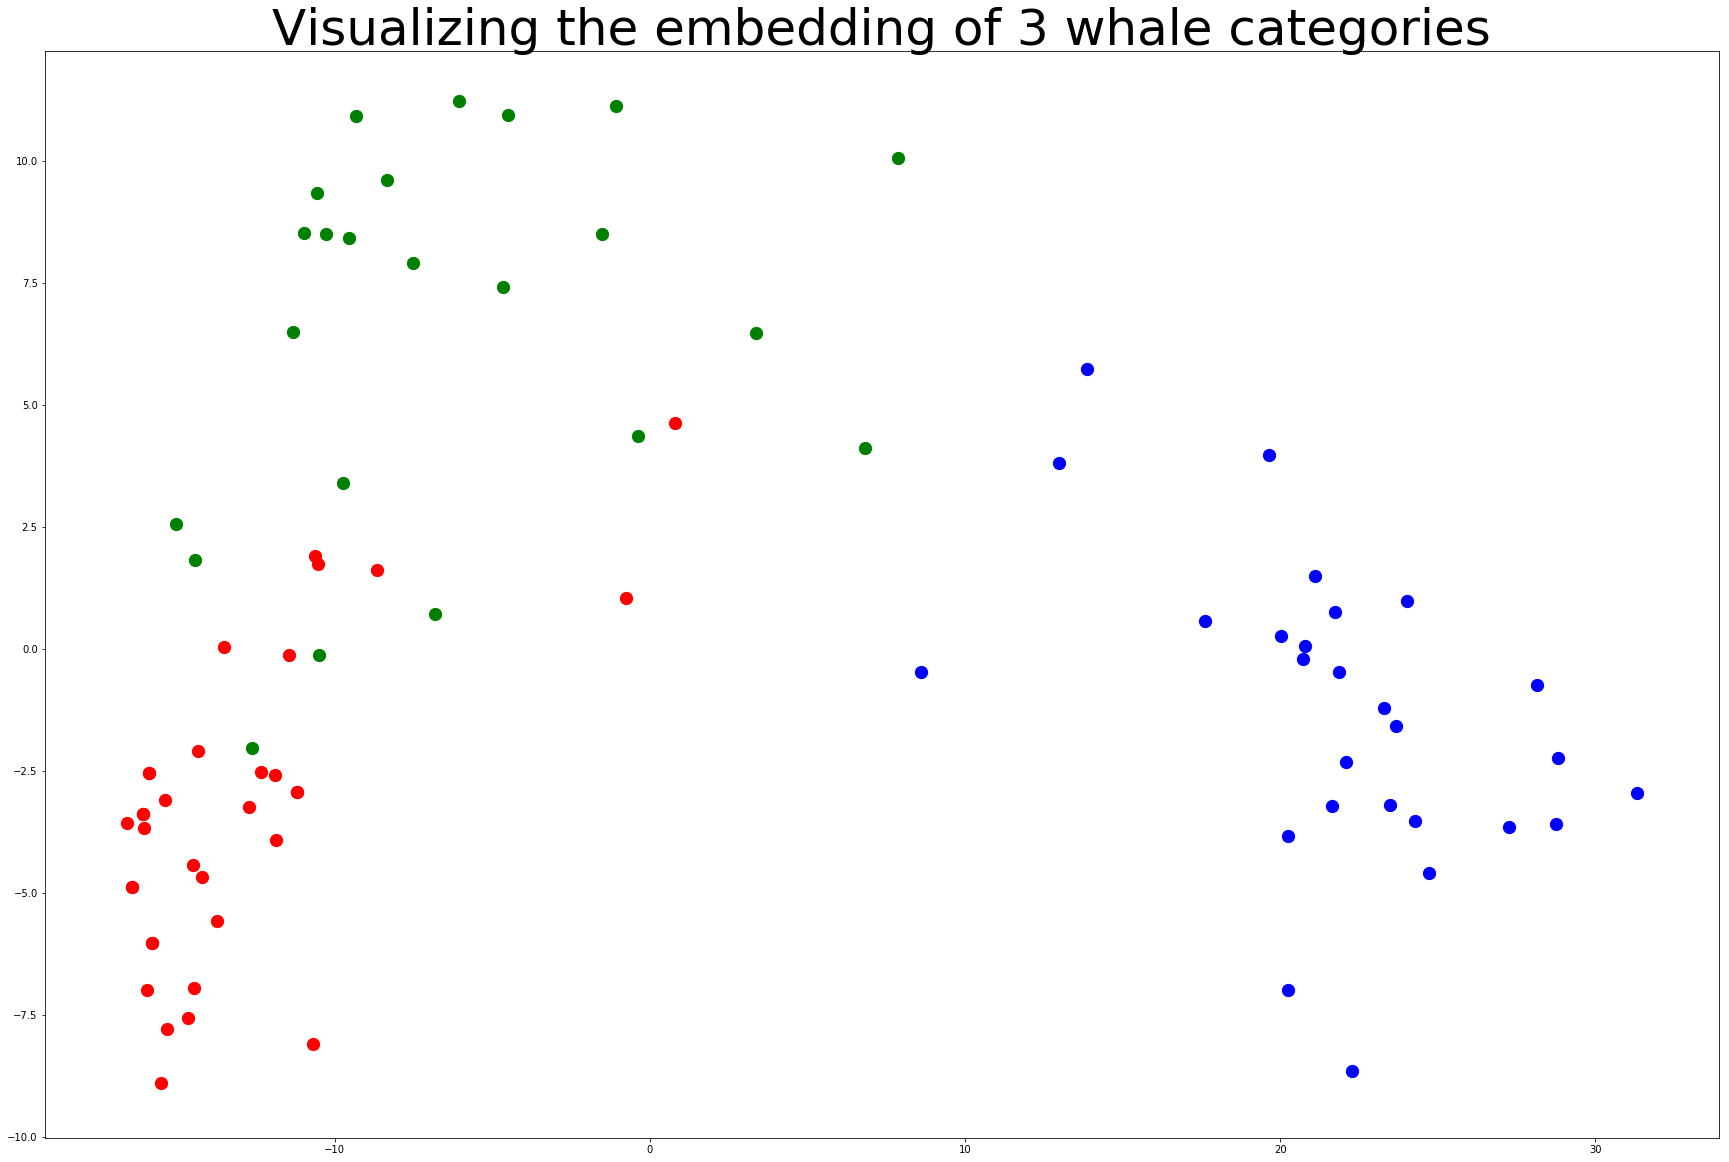

In [289]:
plt.figure(figsize=(30,20))
plt.title("Visualizing the embedding of 3 whale categories", fontsize=50)
for i, c in zip(range(len(vis_id_list)), vis_colour_list):
                 plt.scatter(X_r[i, 0], X_r[i, 1], color=c, s=150)

# Model summary

In [291]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 124, 124, 8)       608       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 62, 62, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 60, 60, 12)        876       
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 30, 30, 12)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 16)        1744      
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 12, 12, 20)        2900      
__________